### Simple Deep learning Model 

#### 1. Importing the necessary import

In [1]:
import os
from os import listdir
from os.path import isfile, join
from glob import glob

import random
import numpy as np
import pandas as pd
from tqdm import tqdm 

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

# from IPython.core.display import display, HTML
# from IPython.display import display
# display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# # %autoreload
# %load_ext autoreload

In [2]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Please install GPU version of TF")

2023-07-26 18:50:52.895538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:50:53.782129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-26 18:50:53.782283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PA

Default GPU Device:/device:GPU:0
Num GPUs Available:  1


2023-07-26 18:50:54.476775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:50:56.349864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:50:56.363272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:50:56.364974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 2. Loading the dataset

In [4]:
from sklearn.datasets import fetch_lfw_pairs

lfw_dataset_train = fetch_lfw_pairs(subset='train',color=True)
lfw_dataset_test = fetch_lfw_pairs(subset='test',color=True)

In [5]:
cnn_train_data = []
for images_paris in lfw_dataset_train['pairs']:
    image1 = images_paris[0]
    image2 = images_paris[1]
    # Stack the two images along the channel axis to create a single image 
    # with dimensions (32, 32, 6)
    combined_image = np.concatenate((image1, image2), axis=0)
    # combined_image = combined_image[:, :, :3]
    cnn_train_data.append(combined_image)
cnn_train_data  = np.stack(cnn_train_data, axis=0)


cnn_test_data = []
for images_paris in lfw_dataset_test['pairs']:
    image1 = images_paris[0]
    image2 = images_paris[1]
    # Stack the two images along the channel axis to create a single image 
    # with dimensions (32, 32, 6)
    combined_image = np.concatenate((image1, image2), axis=0)
    # combined_image = combined_image[:, :, :3]
    cnn_test_data.append(combined_image)
cnn_test_data  = np.stack(cnn_test_data, axis=0)

In [6]:
X_train = cnn_train_data
y_train = lfw_dataset_train['target']

In [7]:
X_test = cnn_test_data
y_test = lfw_dataset_test['target']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_test = label_as_binary.fit_transform(y_test)

In [9]:
from sklearn import preprocessing
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.fit_transform(y_test).toarray()

In [10]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

#### 3. Preparing the model 

In [11]:
def create_simple_model(input_shape, n_out):
    n_out=2
    inputs = tf.keras.Input(shape=(124, 47, 3))
     # = tf.keras.Input(shape=(2,))

    # Load the pre-trained MobileNetV2 model (backbone)
    base_model = tf.keras.applications.ResNet50(include_top=False,
                                                input_tensor=None,
                                                pooling=None,
                                                classes=2
                                                )

    x = base_model(inputs, training=True)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)
    x = Dense(n_out, activation='softmax')(x)
    # outputs = tf.keras.layers.Dense(2)(x)

    model = Model(inputs, x)
    return model

In [12]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

In [13]:
batch_size = 40

model_path = os.path.join("weights", "Resnet_image_classification.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# train_gen = generator.get_batch(batch_size, is_augmented=True, validation=False)
# test_gen = generator.get_batch(400, is_augmented=False, validation=True)

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

# batch_img, _ = next(train_gen)
simple_model = create_simple_model((124,47,3), 2)
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
simple_model.summary()                                                                            

2023-07-26 18:51:11.783802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:51:11.785928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:51:11.787667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:51:11.789453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:51:11.791160: I tensorflow/compiler/xla/stream_executo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 47, 3)]      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 batch_normalization (BatchN  (None, 4, 2, 2048)       8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                             

#### 4. Running the model

In [15]:
with tf.device('/GPU:0'):
    history = simple_model.fit(
        X_train, y_train,
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=(X_test,y_test),
        epochs=100,
        verbose=1,
        callbacks=[reduceLROnPlato, checkPoint]
    )

Epoch 1/100


2023-07-26 18:51:15.085445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


55/55 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.4918
Epoch 1: val_loss improved from inf to 0.71277, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 74s 1s/step - loss: 0.9286 - accuracy: 0.4918 - val_loss: 0.7128 - val_accuracy: 0.5010 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.5077
Epoch 2: val_loss did not improve from 0.71277
55/55 [==============================] - 41s 748ms/step - loss: 0.7666 - accuracy: 0.5077 - val_loss: 0.8093 - val_accuracy: 0.5080 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.5118
Epoch 3: val_loss did not improve from 0.71277
55/55 [==============================] - 40s 736ms/step - loss: 0.7340 - accuracy: 0.5118 - val_loss: 0.8079 - val_accuracy: 0.5010 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.4936
Epoch 4: val_loss improved from 0.71277 to 0.70098, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 74s 1s/step - loss: 0.7433 - accuracy: 0.4936 - val_loss: 0.7010 - val_accuracy: 0.5080 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.5014
Epoch 5: val_loss improved from 0.70098 to 0.69956, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 71s 1s/step - loss: 0.7060 - accuracy: 0.5014 - val_loss: 0.6996 - val_accuracy: 0.5080 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.5068
Epoch 6: val_loss did not improve from 0.69956
55/55 [==============================] - 39s 705ms/step - loss: 0.7346 - accuracy: 0.5068 - val_loss: 0.7008 - val_accuracy: 0.5120 - lr: 0.0100
Epoch 7/100
55/55 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.5141
Epoch 7: val_loss did not improve from 0.69956
55/55 [==============================] - 39s 708ms/step - loss: 0.7145 - accuracy: 0.5141 - val_loss: 0.7092 - val_accuracy: 0.4930 - lr: 0.0100
Epoch 8/100
55/55 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.5082
Epoch 8: val_loss did not improve from 0.69956
55/55 [==============================] - 40s 720ms/step - loss: 0.7630 - accuracy: 0.5082 - val_loss: 0.7416 - val_accuracy: 0.4990 - lr: 0.01

INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 71s 1s/step - loss: 0.7121 - accuracy: 0.4914 - val_loss: 0.6961 - val_accuracy: 0.5110 - lr: 0.0100
Epoch 10/100
55/55 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.5086
Epoch 10: val_loss did not improve from 0.69613
55/55 [==============================] - 41s 747ms/step - loss: 0.7126 - accuracy: 0.5086 - val_loss: 0.7345 - val_accuracy: 0.4990 - lr: 0.0100
Epoch 11/100
55/55 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5005
Epoch 11: val_loss did not improve from 0.69613
55/55 [==============================] - 38s 690ms/step - loss: 0.7036 - accuracy: 0.5005 - val_loss: 0.7163 - val_accuracy: 0.4890 - lr: 0.0100
Epoch 12/100
55/55 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.4909
Epoch 12: val_loss did not improve from 0.69613
55/55 [==============================] - 38s 696ms/step - loss: 0.7120 - accuracy: 0.4909 - val_loss: 0.7405 - val_accuracy: 0.5020 - lr

INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 70s 1s/step - loss: 0.6950 - accuracy: 0.5245 - val_loss: 0.6953 - val_accuracy: 0.4930 - lr: 0.0050
Epoch 18/100
55/55 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5091
Epoch 18: val_loss improved from 0.69530 to 0.69355, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 71s 1s/step - loss: 0.6948 - accuracy: 0.5091 - val_loss: 0.6935 - val_accuracy: 0.4900 - lr: 0.0050
Epoch 19/100
55/55 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5132
Epoch 19: val_loss did not improve from 0.69355
55/55 [==============================] - 38s 696ms/step - loss: 0.6961 - accuracy: 0.5132 - val_loss: 0.6937 - val_accuracy: 0.4990 - lr: 0.0050
Epoch 20/100
55/55 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5268
Epoch 20: val_loss did not improve from 0.69355
55/55 [==============================] - 39s 707ms/step - loss: 0.6927 - accuracy: 0.5268 - val_loss: 0.6942 - val_accuracy: 0.4940 - lr: 0.0050
Epoch 21/100
55/55 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5132
Epoch 21: val_loss improved from 0.69355 to 0.69285, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 71s 1s/step - loss: 0.6935 - accuracy: 0.5132 - val_loss: 0.6929 - val_accuracy: 0.5070 - lr: 0.0050
Epoch 22/100
55/55 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5127
Epoch 22: val_loss did not improve from 0.69285
55/55 [==============================] - 38s 697ms/step - loss: 0.6940 - accuracy: 0.5127 - val_loss: 0.6954 - val_accuracy: 0.5170 - lr: 0.0050
Epoch 23/100
55/55 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.5136
Epoch 23: val_loss improved from 0.69285 to 0.69174, saving model to weights/Resnet_image_classification.hd5


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 71s 1s/step - loss: 0.7014 - accuracy: 0.5136 - val_loss: 0.6917 - val_accuracy: 0.5120 - lr: 0.0050
Epoch 24/100
55/55 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5164
Epoch 24: val_loss did not improve from 0.69174
55/55 [==============================] - 38s 690ms/step - loss: 0.6944 - accuracy: 0.5164 - val_loss: 0.6960 - val_accuracy: 0.5060 - lr: 0.0050
Epoch 25/100
55/55 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5177
Epoch 25: val_loss did not improve from 0.69174
55/55 [==============================] - 39s 703ms/step - loss: 0.6934 - accuracy: 0.5177 - val_loss: 0.6922 - val_accuracy: 0.5240 - lr: 0.0050
Epoch 26/100
55/55 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5205
Epoch 26: val_loss did not improve from 0.69174
55/55 [==============================] - 39s 706ms/step - loss: 0.6929 - accuracy: 0.5205 - val_loss: 0.6953 - val_accuracy: 0.5150 - lr

INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 70s 1s/step - loss: 0.6905 - accuracy: 0.5309 - val_loss: 0.6917 - val_accuracy: 0.5170 - lr: 0.0025
Epoch 32/100
55/55 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5268
Epoch 32: val_loss did not improve from 0.69170
55/55 [==============================] - 37s 681ms/step - loss: 0.6914 - accuracy: 0.5268 - val_loss: 0.6926 - val_accuracy: 0.5150 - lr: 0.0025
Epoch 33/100
55/55 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5359
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 33: val_loss did not improve from 0.69170
55/55 [==============================] - 37s 683ms/step - loss: 0.6897 - accuracy: 0.5359 - val_loss: 0.6959 - val_accuracy: 0.5110 - lr: 0.0025
Epoch 34/100
55/55 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5518
Epoch 34: val_loss did not improve from 0.69170
55/55 [==============================] - 38s 684ms/step - 

INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


INFO:tensorflow:Assets written to: weights/Resnet_image_classification.hd5/assets


55/55 [==============================] - 70s 1s/step - loss: 0.6882 - accuracy: 0.5418 - val_loss: 0.6903 - val_accuracy: 0.5240 - lr: 6.2500e-04
Epoch 40/100
55/55 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5409
Epoch 40: val_loss did not improve from 0.69032
55/55 [==============================] - 38s 687ms/step - loss: 0.6857 - accuracy: 0.5409 - val_loss: 0.6924 - val_accuracy: 0.5150 - lr: 6.2500e-04
Epoch 41/100
55/55 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5514
Epoch 41: val_loss did not improve from 0.69032
55/55 [==============================] - 38s 691ms/step - loss: 0.6842 - accuracy: 0.5514 - val_loss: 0.6928 - val_accuracy: 0.5070 - lr: 6.2500e-04
Epoch 42/100
55/55 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5427
Epoch 42: val_loss did not improve from 0.69032
55/55 [==============================] - 38s 686ms/step - loss: 0.6826 - accuracy: 0.5427 - val_loss: 0.6920 - val_accuracy:

#### 5. Evaluation

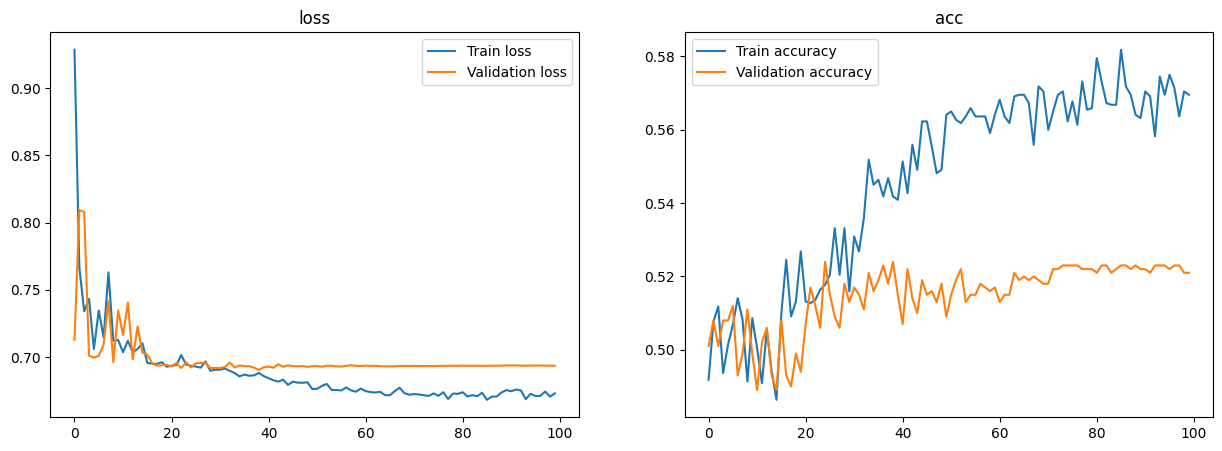

In [16]:
show_history(history)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

predict_idxs = simple_model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

y_test = label_as_binary.fit_transform(y_test)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

25/25 [==============================] - 2s 93ms/step
[[164 336]
 [140 360]]


In [18]:
target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names

In [19]:
target_names

array(['Different persons', 'Same person'], dtype='<U17')

In [20]:
print(classification_report(np.argmax(y_test, axis=1), predict_idxs, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.54      0.33      0.41       500
      Same person       0.52      0.72      0.60       500

         accuracy                           0.52      1000
        macro avg       0.53      0.52      0.50      1000
     weighted avg       0.53      0.52      0.50      1000

